In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor

X_train = pd.read_csv("../data/X_train.csv", index_col=0)
y_train = pd.read_csv("../data/y_train.csv", index_col=0)
X_val = pd.read_csv("../data/X_val.csv", index_col=0)
y_val = pd.read_csv("../data/y_val.csv", index_col=0)

In [8]:
target_col = 'S&P500_target_5d'
y_train_sp500 = y_train[target_col]
y_val_sp500 = y_val[target_col]

In [9]:

model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train_sp500)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [10]:

y_pred = model.predict(X_val)


rmse = rmse = np.sqrt(mean_squared_error(y_val_sp500, y_pred))
mae = mean_absolute_error(y_val_sp500, y_pred)
r2 = r2_score(y_val_sp500, y_pred)

print(f"RMSE: {rmse:.5f}")
print(f"MAE : {mae:.5f}")
print(f"R²  : {r2:.5f}")


RMSE: 0.01565
MAE : 0.00982
R²  : -0.09876


## Model Evaluation for  S&P500 asset

- **RMSE**: 0.01565 → Average prediction error ~1.56%
- **MAE**: 0.00982 → On average, predictions deviate by ~0.98%
- **R² Score**: -0.09876 → Negative R² indicates the model performs worse than simply predicting the mean return.

The low R² suggests limited predictive power. Despite low error values, the model fails to explain return variance effectively — a common challenge in short-horizon financial forecasts.


In [25]:



results = {}

# Looping each target
for target_col in y.columns:
    asset = target_col.split('_')[0]  
    print(f"Training XGBoost for {asset}...")

    
    asset_features = [col for col in X.columns if col.startswith(asset)]
    X_asset = X[asset_features]
    y_asset = y[target_col]

    # Post error, made this edit of dropping Nan. XgBoost doesn't handle Nan's well 
    asset_data = pd.concat([X_asset, y_asset], axis=1).dropna()    
    X_asset_clean = asset_data[asset_features]
    y_asset_clean = asset_data[target_col]

    
    X_train, X_val, y_train, y_val = train_test_split(
        X_asset_clean, y_asset_clean, test_size=0.2, shuffle=False
    )

    # defining the XGBoost model
    model = XGBRegressor(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.005,
        objective='reg:squarederror',
        random_state=42
    )

    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    predictions_df = pd.DataFrame({
    'Date': y_val.index,
    'y_true': y_val.values,
    'y_pred': y_pred
    })
    predictions_df.to_csv(f"../results/{asset}_new_xgb_predictions.csv", index=False)

   
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

 
    results[asset] = {
        'RMSE': round(rmse, 5),
        'MAE': round(mae, 5),
        'R²': round(r2, 5)
    }

# results into datafame to be saved later 
results_df_new = pd.DataFrame(results).T

#Saving results 
results_df_new.to_csv("../results/new_xgboost_metrics.csv")
pd.DataFrame({'y_val': y_val, 'y_pred': y_pred}).to_csv(f"../results/{asset}_new_xgb_preds.csv")

print("\n XGBoost Evaluation Metrics (All Assets):")
display(results_df_new)



🚀 Training XGBoost for EEM...
🚀 Training XGBoost for Gold...
🚀 Training XGBoost for FTSE100...
🚀 Training XGBoost for S&P500...
🚀 Training XGBoost for Nikkei225...
🚀 Training XGBoost for UST10Y...

📊 XGBoost Evaluation Metrics (All Assets):


,RMSE,MAE,R²
EEM,0.01300,0.00963,-0.12596
Gold,0.01167,0.00896,-0.53036
FTSE100,0.00863,0.00626,-0.05630
S&P500,0.01390,0.00924,-0.52942
Nikkei225,0.01463,0.01028,-0.12809
UST10Y,0.02215,0.01676,-0.03293


In [14]:

final_df = pd.read_csv("../data/final_features_with_targets.csv", parse_dates=['Date'], index_col='Date')

feature_cols = [col for col in final_df.columns if not col.endswith('_target_5d')]
target_cols = [col for col in final_df.columns if col.endswith('_target_5d')]

X = final_df[feature_cols]
y = final_df[target_cols]


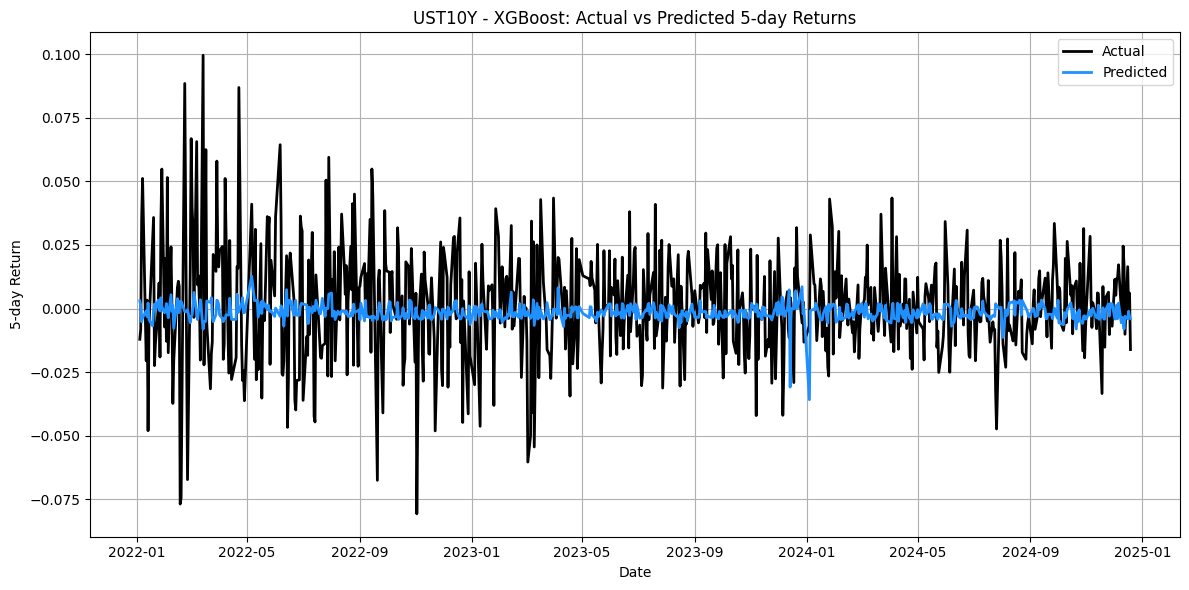

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

asset = "UST10Y"  # change this in a loop for batch visualization if needed
pred_df = pd.read_csv(f"../results/{asset}_new_xgb_predictions.csv", parse_dates=['Date'])

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['y_true'], label='Actual', linewidth=2, color='black')
plt.plot(pred_df['Date'], pred_df['y_pred'], label='Predicted', linewidth=2, color='dodgerblue')
plt.title(f"{asset} - XGBoost: Actual vs Predicted 5-day Returns")
plt.xlabel("Date")
plt.ylabel("5-day Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Some insghts 

XGBoost performed reasonably well across assets but struggled to capture sharp return spikes, especially for volatile assets like Gold and FTSE100.

• Model predictions showed smoother trends but underfit extreme movements, highlighting a limitation in modeling financial return volatility.

• Hyperparameter tuning (lower learning rate, deeper trees, more estimators) improved predictions, particularly reducing downward bias in Gold.

• In general, XGBoost favored stability and mean reversion, but may require more dynamic or sequential learning strategies to model financial time series effectively.
In general xgboost didn't come close to predicting the spikes but followed the general trend and in some invidividual assets like gold needed lot of hyper parameter tunig to even follow the trend


AttributeError: `np.complex_` was removed in the NumPy 2.0 release. Use `np.complex128` instead.